In [73]:
import xgboost as xgb
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
def dbPath() -> Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    db = dc2.joinpath("data/database_final.db")
    return db
def modelPath(lsoaCode:str) ->Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    modelPath = dc2.joinpath(f"data/models/{lsoaCode}.bin")
    return modelPath


In [75]:
conn = sqlite3.connect(dbPath())
query_sunlight = """
SELECT *
FROM sunlight
"""
sunlightDF = pd.read_sql(query_sunlight, conn)
sunlightDF.head()

,index,Sunlight,Year-Month
0,0,2.448102,2001-01-01 00:00:00
1,1,3.125319,2001-02-01 00:00:00
2,2,2.953300,2001-03-01 00:00:00
3,3,4.744445,2001-04-01 00:00:00
4,4,7.725524,2001-05-01 00:00:00


In [76]:
sunlightDF["Year-Month"] = pd.to_datetime(sunlightDF["Year-Month"])
month_dummies = pd.get_dummies(sunlightDF["Year-Month"].dt.month)
sunlightDF = pd.concat([sunlightDF, month_dummies], axis=1)
sunlightDF.drop(columns=["index"], inplace=True)
for i in range(1,12):
    sunlightDF[f"Sunlight_shift_{i}"] = sunlightDF["Sunlight"].shift(i)

sunlightDF = sunlightDF.set_index(sunlightDF["Year-Month"])
sunlightDF.drop(columns = ["Year-Month"], inplace=True)

sunlightDF.dropna(inplace=True)
sunlightDF.head()

,Sunlight,1,2,3,4,5,6,7,8,9,...,Sunlight_shift_2,Sunlight_shift_3,Sunlight_shift_4,Sunlight_shift_5,Sunlight_shift_6,Sunlight_shift_7,Sunlight_shift_8,Sunlight_shift_9,Sunlight_shift_10,Sunlight_shift_11
Year-Month,,,,,,,,,,,,,,,,,,,,,
2001-12-01,2.396143,0,0,0,0,0,0,0,0,0,...,3.582636,4.048802,5.905760,6.388091,6.845211,7.725524,4.744445,2.953300,3.125319,2.448102
2002-01-01,1.495515,1,0,0,0,0,0,0,0,0,...,2.380912,3.582636,4.048802,5.905760,6.388091,6.845211,7.725524,4.744445,2.953300,3.125319
2002-02-01,2.925442,0,1,0,0,0,0,0,0,0,...,2.396143,2.380912,3.582636,4.048802,5.905760,6.388091,6.845211,7.725524,4.744445,2.953300
2002-03-01,3.804281,0,0,1,0,0,0,0,0,0,...,1.495515,2.396143,2.380912,3.582636,4.048802,5.905760,6.388091,6.845211,7.725524,4.744445
2002-04-01,6.616119,0,0,0,1,0,0,0,0,0,...,2.925442,1.495515,2.396143,2.380912,3.582636,4.048802,5.905760,6.388091,6.845211,7.725524


In [77]:
X_train, X_test, y_train, y_test = train_test_split(sunlightDF.drop(columns= ["Sunlight"]),sunlightDF["Sunlight"])

In [78]:
X_train

,1,2,3,4,5,6,7,8,9,10,...,Sunlight_shift_2,Sunlight_shift_3,Sunlight_shift_4,Sunlight_shift_5,Sunlight_shift_6,Sunlight_shift_7,Sunlight_shift_8,Sunlight_shift_9,Sunlight_shift_10,Sunlight_shift_11
Year-Month,,,,,,,,,,,,,,,,,,,,,
2003-11-01,0,0,0,0,0,0,0,0,0,0,...,6.064175,6.977437,5.890142,7.193123,6.390996,6.728073,5.454046,3.623941,2.323001,1.159697
2016-02-01,0,1,0,0,0,0,0,0,0,0,...,1.130998,1.324890,2.995172,5.700259,5.231115,6.059147,7.508897,5.866200,7.082956,4.432794
2006-12-01,0,0,0,0,0,0,0,0,0,0,...,3.221354,5.298549,5.108250,9.285923,7.960759,5.670979,5.574046,3.166268,2.338343,1.690048
2015-08-01,0,0,0,0,0,0,0,1,0,0,...,7.508897,5.866200,7.082956,4.432794,3.147091,2.235379,2.264537,2.002512,3.178991,4.597112
2017-05-01,0,0,0,0,1,0,0,0,0,0,...,3.834734,1.995872,2.069591,1.647453,2.664534,3.605314,4.417997,6.878526,6.323818,4.364186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-01,0,0,0,0,0,1,0,0,0,0,...,4.272551,2.752046,3.741963,1.916567,1.842672,2.637034,2.661436,3.799847,5.868933,5.879392
2021-05-01,0,0,0,0,1,0,0,0,0,0,...,3.750800,2.608182,1.419847,1.557327,2.094819,2.214342,5.412225,5.204964,5.628861,6.178656
2004-10-01,0,0,0,0,0,0,0,0,0,1,...,5.733611,5.576845,6.985119,6.853933,4.786704,3.712269,2.901360,1.684897,1.735241,2.344859


In [79]:
model = xgb.XGBRegressor()
model.fit(X_train.values, y_train)
model.save_model(modelPath("sunlight"))

In [80]:
predictions= model.predict(X_test.values)
pred_train = model.predict(X_train.values)

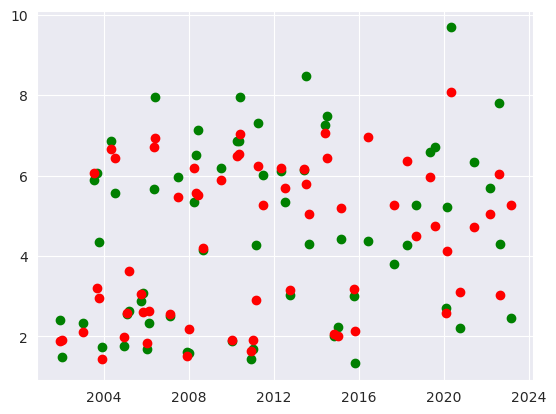

In [83]:
# plt.scatter(X_train.index, y_train)
plt.scatter(X_test.index, y_test, color="green")
plt.scatter(X_test.index, predictions, color="red")
plt.show()

In [82]:
mse_train = mean_squared_error(y_train.values, pred_train)
mae_train = mean_absolute_error(y_train.values, pred_train)
r2_train = r2_score(y_train.values, pred_train)
medae_train = median_absolute_error(y_train.values, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test.values, predictions)
mae_test = mean_absolute_error(y_test.values, predictions)
r2_test = r2_score(y_test.values, predictions)
medae_test = median_absolute_error(y_test.values, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}
metricsDF = pd.DataFrame(metrics)
metricsDF


,Metric,Train Value,Test Value
0,MSE,6.737992e-07,1.145438
1,MAE,5.675406e-04,0.782731
2,R^2,9.999998e-01,0.761392
3,MedAE,3.746855e-04,0.617862
